### Import packages & load data

In [1]:
!pip install -U statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!wget -nc https://lazyprogrammer.me/course_files/sp500sub.csv

File ‘sp500sub.csv’ already there; not retrieving.



In [4]:
!head sp500sub.csv

Date,Open,High,Low,Close,Adj Close,Volume,Name
2010-01-04,9.220000267028807,9.510000228881836,9.170000076293944,9.5,9.5,1865400.0,INCY
2010-01-05,9.510000228881836,10.289999961853027,9.449999809265137,10.270000457763672,10.270000457763672,7608900.0,INCY
2010-01-06,10.380000114440918,11.09000015258789,10.350000381469727,11.0,11.0,8046700.0,INCY
2010-01-07,11.0,11.0600004196167,10.619999885559082,10.81999969482422,10.81999969482422,3680300.0,INCY
2010-01-08,10.81999969482422,11.0,10.75,10.9399995803833,10.9399995803833,1529300.0,INCY
2010-01-11,10.960000038146973,11.239999771118164,10.880000114440918,11.09000015258789,11.09000015258789,2280600.0,INCY
2010-01-12,10.989999771118164,11.0,10.34000015258789,10.359999656677246,10.359999656677246,4204600.0,INCY
2010-01-13,10.359999656677246,10.460000038146973,10.039999961853027,10.329999923706056,10.329999923706056,2134900.0,INCY
2010-01-14,10.3100004196167,10.390000343322754,10.079999923706056,10.15999984741211,10.15999984741211,2889600.0,INCY

In [5]:
!tail sp500sub.csv

2018-12-14,44.20000076293945,44.2400016784668,43.4900016784668,43.54999923706055,42.1451301574707,6502000.0,MDLZ
2018-12-17,43.68999862670898,43.77000045776367,42.599998474121094,42.810001373291016,41.42900466918945,7848900.0,MDLZ
2018-12-18,42.9900016784668,43.20000076293945,41.86000061035156,42.13999938964844,40.780616760253906,10439500.0,MDLZ
2018-12-19,42.4900016784668,42.65999984741211,41.2400016784668,41.40999984741211,40.07416534423828,11258800.0,MDLZ
2018-12-20,41.38999938964844,41.599998474121094,40.5099983215332,41.15999984741211,39.83223342895508,11418300.0,MDLZ
2018-12-21,41.0,41.900001525878906,40.36999893188477,40.68000030517578,39.367713928222656,17481400.0,MDLZ
2018-12-24,40.72000122070313,40.849998474121094,39.20000076293945,39.47999954223633,38.20642471313477,6641300.0,MDLZ
2018-12-26,39.61999893188477,40.02999877929688,38.77999877929688,40.0,38.70965194702149,8640100.0,MDLZ
2018-12-27,39.790000915527344,40.2599983215332,39.18999862670898,40.22999954223633,38.93222808

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import r2_score

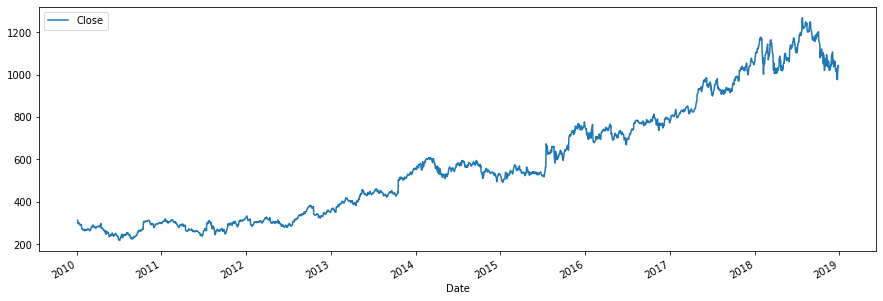

In [10]:
df = pd.read_csv('sp500sub.csv', index_col='Date', parse_dates=True)
goog = df[df['Name'] == 'GOOG'][['Close']].copy()
goog.plot(figsize=(15,5));

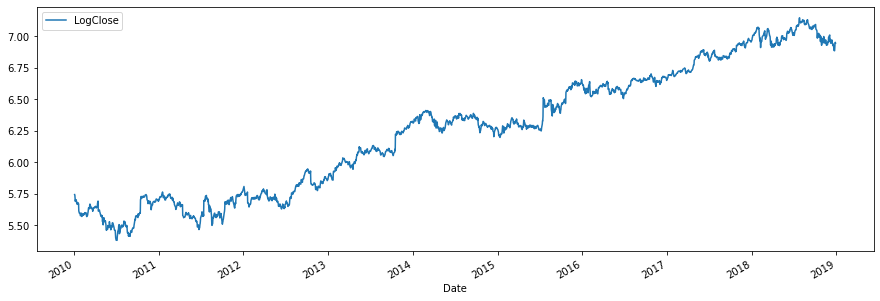

In [11]:
# Prices seems to follow an exponential growth (their log looks linear)
goog['LogClose'] = np.log(goog['Close'])
goog[['LogClose']].plot(figsize=(15,5));

### Functions for walkthrough validation and grid search

In [13]:
import itertools
import sklearn.metrics

def walkthrough(df, step_size, n_steps, scoring, **kwargs):
  Ntrain = len(df) - step_size - n_steps + 1
  score = []
  for end_train in range(Ntrain, len(df) - step_size + 1):
    df_train = df.iloc[:end_train]
    df_test = df.iloc[end_train: end_train + step_size]
    hw = ExponentialSmoothing(df_train, **kwargs)
    hw_res = hw.fit()
    score.append(scoring(hw_res.forecast(step_size), df_test))
  return np.mean(score)

def grid_search(df, params_grid, step_size, n_steps,
                scoring=sklearn.metrics.r2_score, greater_is_better=True):
  score_sign = +1 if greater_is_better else -1
  best_score = float('-inf')
  best_model = None
  for args in itertools.product(*params_grid.values()):
    kwargs = dict(zip(params_grid.keys(), args))
    score = walkthrough(df, step_size, n_steps, scoring, **kwargs)
    if score_sign * (score - best_score) > 0:
      best_model, best_score = kwargs, score
      print(f'Best {scoring.__name__} so far: {best_score:.4f}')
  return best_model, {scoring.__name__: best_score}

### Grid search with walkthrough validation

In [26]:
# We could directly consider LogClose, but instead we fit against Close and
# include boxcox and log transform to the hyperparameters grid search.
params_grid = {
  'initialization_method': ['legacy-heuristic', 'heuristic', 'estimated'],
  'trend': ['add', 'mul'],
  'damped_trend': [False, True],
  'seasonal': [None],  # no obvious seasonality for this data
  'use_boxcox': [False, True, 0]  # 0 = Log
}

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', RuntimeWarning)
warnings.simplefilter('ignore', ValueWarning)

best_model, best_score = grid_search(goog['Close'], params_grid, step_size=12, n_steps=10)
print('\nBest model:')
print(', '.join([f'{k}: {v:.4f}' for k,v in best_score.items()]))
for k,v in best_model.items():
  print(f'{k}: {v}')

Best r2_score so far: -7151.4146
Best r2_score so far: -440.9735
Best r2_score so far: 0.0000

Best model:
r2_score: 0.0000
initialization_method: legacy-heuristic
trend: add
damped_trend: True
seasonal: None
use_boxcox: 0


Train R2 =  1.00
Test  R2 = -0.07


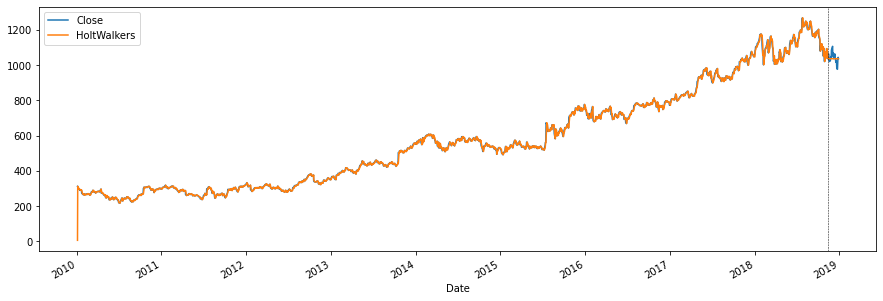

In [31]:
# Fit the best model to the data
Ntest = 30  # 1 month
goog_train = goog.iloc[:-Ntest]['Close']
goog_test = goog.iloc[-Ntest:]['Close']
hw = ExponentialSmoothing(goog_train, **best_model)
hw_res = hw.fit()
# Score
hw_forecast = hw_res.forecast(Ntest).to_numpy()  # required since the absence of freq messes up the index
print(f'Train R2 = {r2_score(goog_train, hw_res.fittedvalues):5.2f}')
print(f'Test  R2 = {r2_score(goog_test, hw_forecast):5.2f}')
# Plot
goog['HoltWalkers'] = np.concatenate([hw_res.fittedvalues.to_numpy(), hw_forecast])
goog[['Close', 'HoltWalkers']].plot(figsize=(15,5));
plt.axvline(x=goog.index[-Ntest], color='black', ls='--', lw=.5);
plt.show()

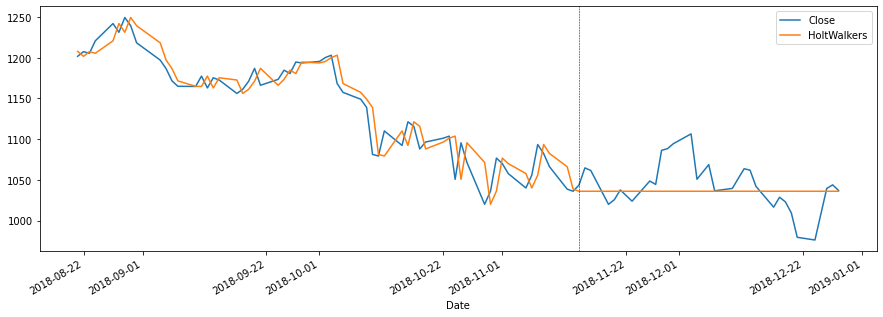

In [32]:
# Zoom on last 3 months.
# Remarks: the best model seems to be a naive forecast copying the previous value.
# This is why it performs well on the train set (R2=1), but poorly (R2<0) on the test set.
goog.iloc[-90:][['Close', 'HoltWalkers']].plot(figsize=(15,5));
plt.axvline(x=goog.index[-Ntest], color='black', ls='--', lw=.5);
plt.show()

### TODO: Compare against a naive forecast